In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load the datasets
train_labels = pd.read_csv(r"C:\Users\VIdhibhardwaj\Downloads\dataset and all\training_set_labels.csv")
train_features = pd.read_csv(r"C:\Users\VIdhibhardwaj\Downloads\dataset and all\training_set_features.csv")
test_features = pd.read_csv(r"C:\Users\VIdhibhardwaj\Downloads\dataset and all\test_set_features.csv")

In [4]:
# Merge the training labels with the training features
train_df = train_features.merge(train_labels, on='respondent_id')

In [5]:
# Separate features and targets in the training data
X_train = train_df.drop(columns=['respondent_id', 'xyz_vaccine', 'seasonal_vaccine'])
y_train = train_df[['xyz_vaccine', 'seasonal_vaccine']]

In [7]:
# Preprocessing pipelines for both numerical and categorical data
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [8]:
# Define the model (using LogisticRegression)
model = MultiOutputClassifier(LogisticRegression(max_iter=1000, random_state=42))

In [9]:
# Create and train the pipeline
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])

In [10]:
# Split the training data into training and validation sets for evaluation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
# Train the model
clf.fit(X_train_split, y_train_split)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['xyz_concern', 'xyz_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_hom...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('classifier',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                    random_state=42)))])

In [12]:
# Predict probabilities on the validation set
y_val_pred_proba = clf.predict_proba(X_val_split)

In [13]:
# Convert the list of arrays into a single 2D array
y_val_pred_proba = np.column_stack([y_val_pred_proba[i][:, 1] for i in range(len(y_val_pred_proba))])

In [14]:
# Calculate ROC AUC score
roc_auc = roc_auc_score(y_val_split, y_val_pred_proba, average="macro")
print(f'Validation ROC AUC Score: {roc_auc}')

Validation ROC AUC Score: 0.8437087383177688


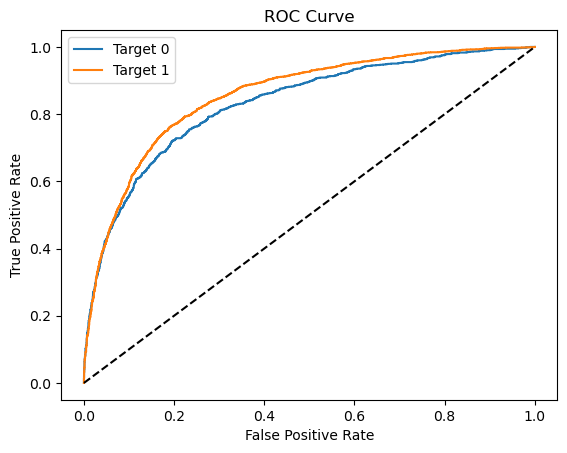

In [15]:
# Plot ROC curves
fpr = {}
tpr = {}
threshold = {}
for i in range(2):
    fpr[i], tpr[i], threshold[i] = roc_curve(y_val_split.iloc[:, i], y_val_pred_proba[:, i])
    plt.plot(fpr[i], tpr[i], label=f'Target {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [16]:
# Prepare the test data for prediction
X_test = test_features.drop(columns=['respondent_id'])

In [17]:
# Predict probabilities for the test data
test_preds_proba = clf.predict_proba(X_test)
test_preds_proba = np.column_stack([test_preds_proba[i][:, 1] for i in range(len(test_preds_proba))])

In [18]:
# Create the submission file
submission = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'xyz_vaccine': test_preds_proba[:, 0],
    'seasonal_vaccine': test_preds_proba[:, 1]
})

submission.to_csv('submission.csv', index=False)
print('Submission file created successfully.')

Submission file created successfully.


In [19]:
submission.head()

,respondent_id,xyz_vaccine,seasonal_vaccine
0,26707,0.049981,0.297147
1,26708,0.046352,0.046435
2,26709,0.366802,0.515458
3,26710,0.514131,0.881465
4,26711,0.150160,0.457518
